In [1]:
# in this version, the tresholding is automated.

%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
import pims
from PIL import Image

In [2]:
def drawX(centerPx,length,A,size):
    resultImage = np.zeros((size[0], size[1]))
    centerPx = np.array(centerPx).astype(int)
    for x in range(centerPx[0]-int(length/2),centerPx[0]+int(length/2)+1):
        #print(x)
        resultImage[centerPx[1]-2,x] = A
        resultImage[centerPx[1]-1,x] = A
        resultImage[centerPx[1],x] = A
        resultImage[centerPx[1]+1,x] = A
        resultImage[centerPx[1]+2,x] = A
    for y in range(centerPx[1]-int(length/2),centerPx[1]+int(length/2)+1):
        resultImage[y,centerPx[0]-2] = A
        resultImage[y,centerPx[0]-1] = A
        resultImage[y,centerPx[0]] = A
        resultImage[y,centerPx[0]+1] = A
        resultImage[y,centerPx[0]+2] = A
    return resultImage

In [3]:
def getXandYArrayGivenCenter(centerPx,img,averagingMargin):
    xArray = np.average(img[:,centerPx[0]-averagingMargin:centerPx[0]+averagingMargin],axis=1)
    yArray = np.average(img[centerPx[1]-averagingMargin:centerPx[1]+averagingMargin,:],axis=0)
    return[xArray,yArray]

In [4]:
# user input
vesicleID = 1

correction=[0,0]
folder = './'

filename_movie = "example__guv_movie.tif"
filename_centers = "example__guv_centers.csv"


# automated from here
dfcenters = pd.read_csv(''.join([folder,'/',filename_centers]))

xCenter = dfcenters[dfcenters['id'] == vesicleID]['x'].astype(float).values[0]
yCenter = dfcenters[dfcenters['id'] == vesicleID]['y'].astype(float).values[0]
center0 = np.array([xCenter+correction[0],yCenter+correction[0]])
print(center0)

#ltopxConversion =512/70
ltopxConversion = 1
center0px = (center0*ltopxConversion).astype(int)
print("center of cross: {}".format(center0px))
movie_filename = ''.join([folder,'/',filename_movie])
print(movie_filename)



all_movie_frames = pims.TiffStack_pil(movie_filename)

ch0_s = slice(0,len(all_movie_frames),2) 
ch1_s = slice(1,len(all_movie_frames),2) 


ch0 = all_movie_frames[ch0_s]
ch1 = all_movie_frames[ch1_s]



[74. 88.]
center of cross: [74 88]
.//example__guv_movie.tif


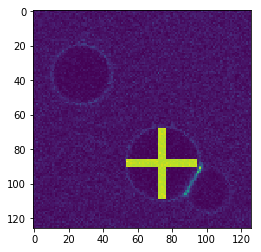

In [6]:
# show the center proposal ontop of the raw data
image = ch1[20]
plt.show()
crossImage = drawX(center0px,40,2000,[image.shape[0],image.shape[1]])
summedImage = image + crossImage
plt.imshow(summedImage)
plt.savefig(movie_filename+"_vesicleID_"+str(vesicleID)+"_overview.png")

In [7]:
def calculateThreshold(center,image,margin=5):
    insideGUV = np.average(image[center[1]-margin:center[1]+margin,center[0]-margin:center[0]+margin])
    xArray = np.average(image[:,0:30],axis=1)# get the first n lines of the img in x
    yArray = np.average(image[0:30,:],axis=0)# get the first n lines of the img in y
    background=(np.average(xArray)+np.average(yArray))/2
    treshold = insideGUV+(background-insideGUV)/2
    if(insideGUV>background):
        treshold = 1.2*insideGUV
    return [treshold,insideGUV,background]

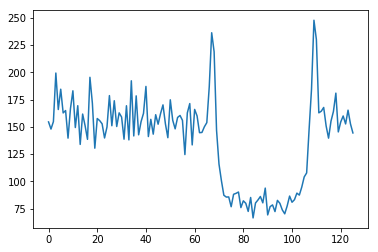

amplitudes treshold: 117.95309523809524, insideGUV: 80.93, outside background: 154.97619047619048


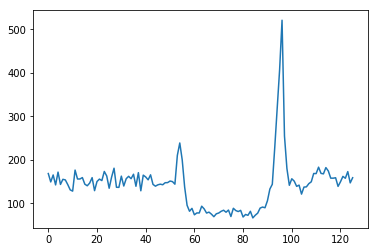

In [8]:
xArray, yArray = getXandYArrayGivenCenter(center0px,image,10)
plt.plot(xArray)
plt.show()
plt.plot(yArray)
tresholdCalc = calculateThreshold(center0px,image)
print("amplitudes treshold: {}, insideGUV: {}, outside background: {}".format(tresholdCalc[0],tresholdCalc[1],tresholdCalc[2]))

In [9]:
def plot3ChannelImage(frames,filename):
    fig = plt.figure(dpi=150)
    ax = fig.subplots(nrows=1, ncols=3)
    
    plt.subplot(1, 3, 1)
    plt.imshow(frames[0])
    plt.subplot(1, 3, 2)
    plt.imshow(frames[1])
    plt.subplot(1, 3, 3)
    plt.imshow(frames[2])
    #plt.title(filename)
    plt.tight_layout()

#    plt.imsave('figc.png',figc,cmap=None)
    plt.savefig(str('./'+filename+'.png'))#,figc,cmap=None)

In [10]:
#get the amplitude in the center

#get the background amplitude

#define the threshold
def computeBoundariesMiddleOut(center,image,tresholds,avgSize=10,verbose=False):
    
        

    #print(verbose)
    xArray, yArray = getXandYArrayGivenCenter(center,image,avgSize)
#pick the points immediately left and right to the center that go through the treshold
#split into two arrays a = xArray[0:centerPx[0]], b = xArray[centerPx[0]:-1]
    x_threshold = tresholds[0]
    left_x_SearchArray = xArray[0:center[1]]
    try:    
        x_idxLeft = np.nonzero(left_x_SearchArray>x_threshold)[0][-1]
    except IndexError:
        x_idxLeft = 0     


    right_x_SearchArray = xArray[center[1]:-1]
    try:
        x_idxRight = center[1]+np.nonzero(right_x_SearchArray>x_threshold)[0][0]
    except IndexError:
        x_idxRight = image.shape[0] 

    if(verbose):
        #plt.plot(left_x_SearchArray)
        #plt.show()
        #plt.plot(right_x_SearchArray)
        #plt.show()
        print("x_threshold {}".format(x_threshold))
        print("computeBoundariesMiddleOut: x left {} right {}".format(x_idxLeft,x_idxRight))
        
        
        #plt.gray()
        fig, axes = plt.subplots(ncols=2, figsize=(8, 2))
        ax = axes.ravel()
        ax[0].plot(xArray)
        ax[0].set_title('yArray')
        ax[0].axvline(x=x_idxLeft,c='r')
        ax[0].axvline(x=x_idxRight,c='r')


###------


    y_threshold =  tresholds[1]
    left_y_SearchArray = yArray[0:center[0]]
    try:
        y_idxLeft = np.nonzero(left_y_SearchArray>y_threshold)[0][-1]
    except IndexError:
        y_idxLeft = 0
    
    right_y_SearchArray = yArray[center[0]:-1]
    try:
        y_idxRight = center[0]+np.nonzero(right_y_SearchArray>y_threshold)[0][0]
    except IndexError:
        y_idxRight = image.shape[1]     
    #print("x left {} right {}".format(y_idxLeft,y_idxRight))
    
    if(verbose):
        ax[1].plot(yArray)
        ax[1].set_title('xArray')
        ax[1].axvline(x=y_idxLeft,c='r')
        ax[1].axvline(x=y_idxRight,c='r')
        plt.show()
    
    return [x_idxLeft,x_idxRight,y_idxLeft,y_idxRight]

In [11]:
def computeNewCircle(center,image,tresholds,verbose=False):
    x_idxLeft,x_idxRight,y_idxLeft,y_idxRight = computeBoundariesMiddleOut(center0px,img,tresholds,verbose=verbose)
    xdist = x_idxRight-x_idxLeft
    ydist = y_idxRight-y_idxLeft
    centerX = x_idxLeft+int((xdist)/2)
    centerY = y_idxLeft+int((ydist)/2)
    #radius = np.mean(np.array([xdist,ydist]))/2
    radius = 1.1*np.max(np.array([xdist,ydist]))/2
    return(centerX,centerY,radius)

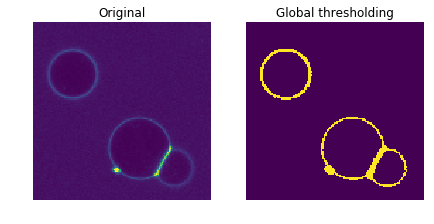

In [12]:
from skimage.filters import threshold_otsu, threshold_local
#from skimage.filters import threshold_minimum
from skimage.filters import threshold_yen
from skimage.filters import threshold_li
from skimage.filters import threshold_triangle


image = ch0[30]

global_thresh = threshold_otsu(image)
global_thresh = threshold_li(image)
binary_global = image > global_thresh



fig, axes = plt.subplots(ncols=2, figsize=(7, 8))
ax = axes.ravel()
#plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')


for a in ax:
    a.axis('off')

plt.show()

[  0 255]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

[74 88]
treshold: 122.89884920634918, insideGUV: 55.71, outside background: 190.0876984126984, 
x_threshold 122.89884920634918
computeBoundariesMiddleOut: x left 70 right 106


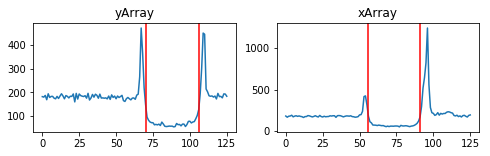

centerx 88 centery 73
[[[73, 88, 19.8]]]


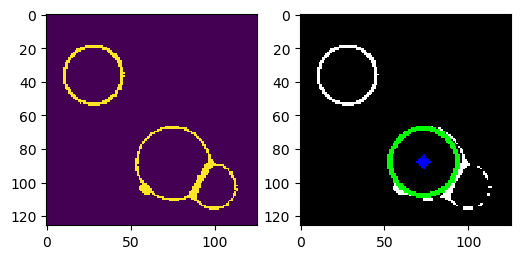

In [13]:
#frames = allImages[5]


img2 = binary_global.astype('uint8')*255
#img2 = img_fijiThreshold
print(np.unique(img2))
print(img2)
print()
#binary_global.astype('uint8')
#plt.imshow(img2)
#img8 = (img2/256).astype('uint8')
img8 = img2

img = cv2.medianBlur(img8,3)
#plt.imshow(img)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)


img = ch0[20]
print(center0px)
tresholdCalc = calculateThreshold(center0px,img)
thresholds_xy= [tresholdCalc[0],tresholdCalc[0]]
print("treshold: {}, insideGUV: {}, outside background: {}, ".format(tresholdCalc[0],tresholdCalc[1],tresholdCalc[2]))
centerx, centery, radius = computeNewCircle(center0px,img,thresholds_xy,verbose=True)
print("centerx {} centery {}".format(centerx,centery))
circles = [[[centery,centerx,radius]]]

print(circles)
#circles is literally:
#    [xCoord,yCoord,Radius]
# [[[ 279.75        276.75        105.45200348]]]

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

#cv2.imshow('detected circles',cimg)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

fig = plt.figure(dpi=100)
ax = fig.subplots(nrows=1, ncols=2)
    
plt.subplot(1, 2, 1)
plt.imshow(img2)
plt.subplot(1, 2, 2)
plt.imshow(cimg)

#plt.show()

In [14]:
circlesPerFrame = []
frameDropped = []
verbose = False

frameId = 0
#print(ch0)
for image in ch0:

    global_thresh = threshold_li(image)
    binary_global = image > global_thresh
    
    img = binary_global.astype('uint8')*255
    
    
    img = cv2.medianBlur(img,3)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    
    
    #circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1.5,220,param1=20,param2=30,minRadius=30,maxRadius=100)
# before 2018-05-08    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,220,param1=20,param2=30,minRadius=30,maxRadius=100)
    #circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1.5,200,param1=20,param2=30,minRadius=100,maxRadius=200)
    
    img = image
    #print(center0px)
    tresholdCalc = calculateThreshold(center0px,img)
    thresholds_xy= [tresholdCalc[0],tresholdCalc[0]]
    if(verbose):
        print("treshold: {}, insideGUV: {}, outside background: {}, ".format(tresholdCalc[0],tresholdCalc[1],tresholdCalc[2]))
    centerx, centery, radius = computeNewCircle(center0px,img,thresholds_xy,verbose=verbose)
    #print("centerx {} centery {}".format(centerx,centery))
    circles = [[[centery,centerx,radius]]]
    
    arrayLen = -1
    try:
        arrayLen = len(circles)
    except TypeError: 
        frameDropped.append([frameId,True])
        print("FRAME DROPPED")
        circlesPerFrame.append([[]])
        frameId = frameId+1
        continue
    if(arrayLen != -1):
        circles = np.uint16(np.around(circles))
        
        
        
    circlesPerFrame.append(circles[0])
    
    if(verbose):
        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        
        #cv2.imshow('detected circles',cimg)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        
        fig = plt.figure(figsize=(7,2),dpi=300)
    
        ax = fig.subplots(nrows=1, ncols=3)
        print("frameId = {}/{}".format(frameId,len(ch0)))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.subplot(1, 3, 2)
        plt.imshow(img)
        plt.subplot(1, 3, 3)
        plt.imshow(cimg)
        #plt.tight_layout()
        plt.subplots_adjust(hspace=0.01,wspace=0.3)
        frameDropped.append([frameId,False]) 
        frameId = frameId+1




# Calculate the intensities from each image

IMAGE ID:  0
+++++++++++++++++++++++++++++++++++++++++++++
[[73 86 21]]
INDEX:  0


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


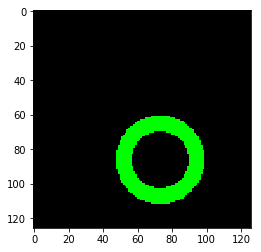

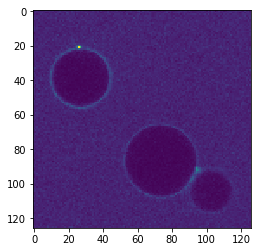

averagePixelIntensity ch1_frame  140.59
averageBackground ch1_frame  155.14285714285714
averagePixelIntensity ch2_frame  120.96
averageBackground ch2_frame  132.75661375661375
---
IMAGE ID:  1
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


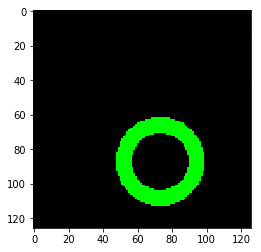

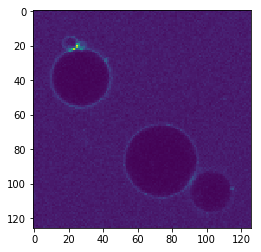

averagePixelIntensity ch1_frame  147.59
averageBackground ch1_frame  165.64523809523808
averagePixelIntensity ch2_frame  123.71
averageBackground ch2_frame  136.74510582010583
---
IMAGE ID:  2
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


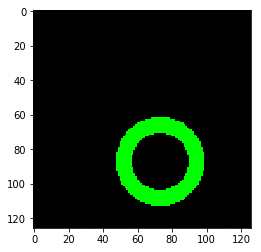

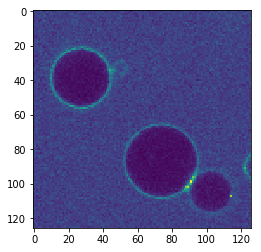

averagePixelIntensity ch1_frame  160.84
averageBackground ch1_frame  163.57566137566135
averagePixelIntensity ch2_frame  130.24
averageBackground ch2_frame  138.53214285714284
---
IMAGE ID:  3
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


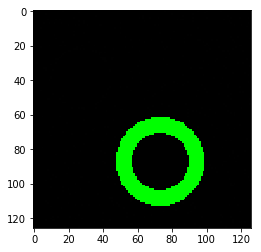

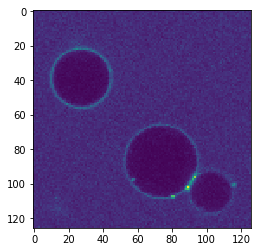

averagePixelIntensity ch1_frame  172.49
averageBackground ch1_frame  166.76071428571427
averagePixelIntensity ch2_frame  132.04
averageBackground ch2_frame  140.89603174603172
---
IMAGE ID:  4
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


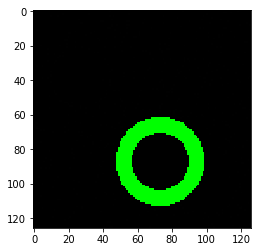

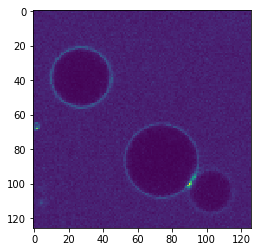

averagePixelIntensity ch1_frame  179.93
averageBackground ch1_frame  169.72910052910055
averagePixelIntensity ch2_frame  137.69
averageBackground ch2_frame  141.1280423280423
---
IMAGE ID:  5
+++++++++++++++++++++++++++++++++++++++++++++
[[73 86 20]]
INDEX:  0


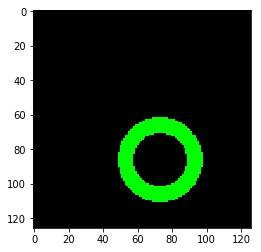

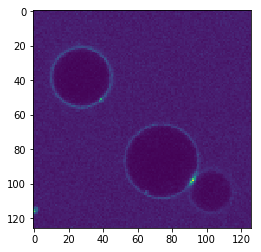

averagePixelIntensity ch1_frame  172.88
averageBackground ch1_frame  171.13174603174605
averagePixelIntensity ch2_frame  131.66
averageBackground ch2_frame  143.2382275132275
---
IMAGE ID:  6
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


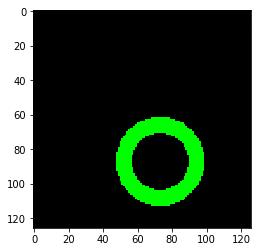

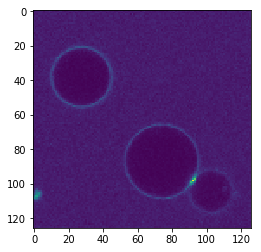

averagePixelIntensity ch1_frame  189.76
averageBackground ch1_frame  174.569708994709
averagePixelIntensity ch2_frame  137.06
averageBackground ch2_frame  144.92962962962963
---
IMAGE ID:  7
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


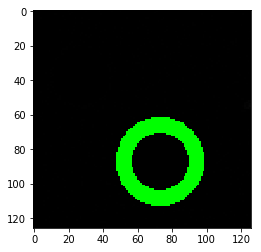

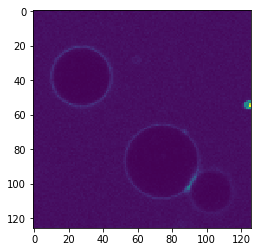

averagePixelIntensity ch1_frame  204.93
averageBackground ch1_frame  173.85026455026457
averagePixelIntensity ch2_frame  146.25
averageBackground ch2_frame  145.2589947089947
---
IMAGE ID:  8
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


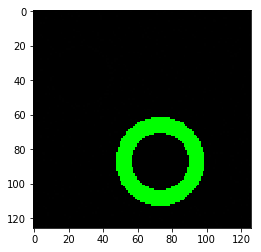

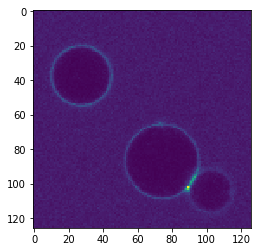

averagePixelIntensity ch1_frame  211.57
averageBackground ch1_frame  175.03849206349201
averagePixelIntensity ch2_frame  149.26
averageBackground ch2_frame  145.83201058201058
---
IMAGE ID:  9
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


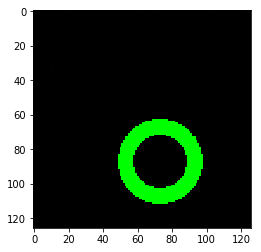

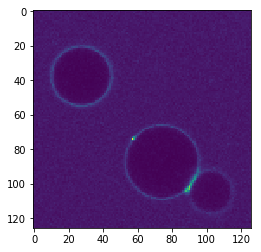

averagePixelIntensity ch1_frame  216.65
averageBackground ch1_frame  175.6820105820106
averagePixelIntensity ch2_frame  147.23
averageBackground ch2_frame  148.18280423280424
---
IMAGE ID:  10
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 21]]
INDEX:  0


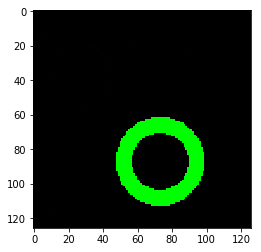

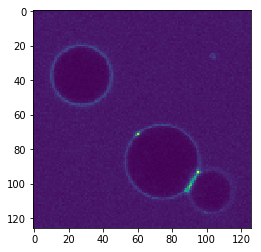

averagePixelIntensity ch1_frame  236.51
averageBackground ch1_frame  177.0679894179894
averagePixelIntensity ch2_frame  156.75
averageBackground ch2_frame  148.41097883597882
---
IMAGE ID:  11
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


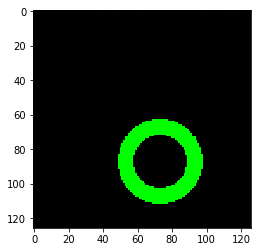

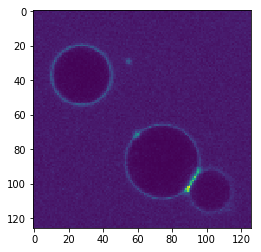

averagePixelIntensity ch1_frame  231.91
averageBackground ch1_frame  178.71190476190475
averagePixelIntensity ch2_frame  150.89
averageBackground ch2_frame  148.99761904761905
---
IMAGE ID:  12
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


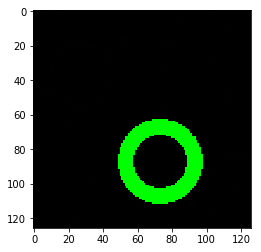

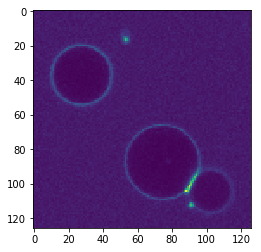

averagePixelIntensity ch1_frame  229.89
averageBackground ch1_frame  181.1820105820106
averagePixelIntensity ch2_frame  148.31
averageBackground ch2_frame  150.66415343915344
---
IMAGE ID:  13
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


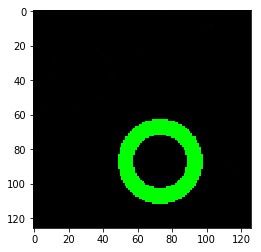

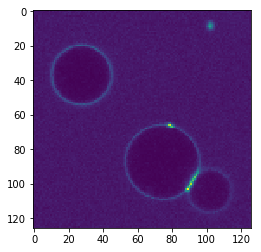

averagePixelIntensity ch1_frame  246.43
averageBackground ch1_frame  182.05171957671956
averagePixelIntensity ch2_frame  162.69
averageBackground ch2_frame  149.65052910052907
---
IMAGE ID:  14
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


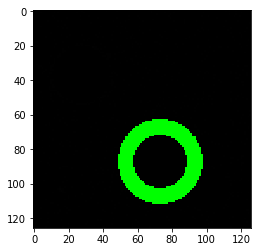

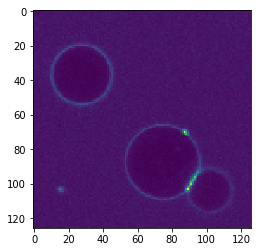

averagePixelIntensity ch1_frame  254.78
averageBackground ch1_frame  181.930291005291
averagePixelIntensity ch2_frame  158.42
averageBackground ch2_frame  150.80092592592592
---
IMAGE ID:  15
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


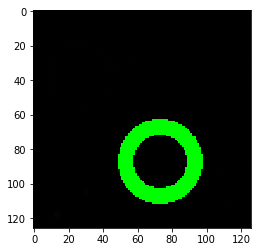

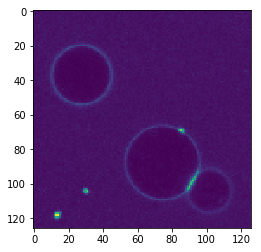

averagePixelIntensity ch1_frame  256.67
averageBackground ch1_frame  186.08611111111105
averagePixelIntensity ch2_frame  163.65
averageBackground ch2_frame  153.4275132275132
---
IMAGE ID:  16
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


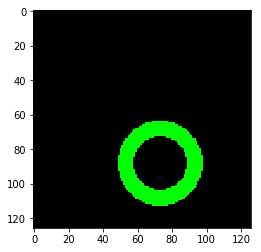

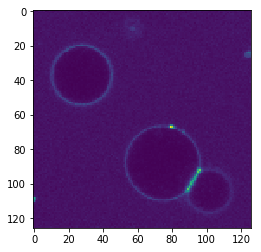

averagePixelIntensity ch1_frame  275.33
averageBackground ch1_frame  188.1337301587302
averagePixelIntensity ch2_frame  168.65
averageBackground ch2_frame  152.28425925925924
---
IMAGE ID:  17
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


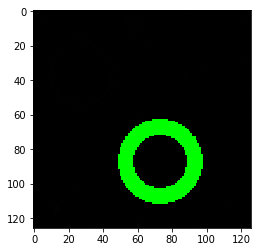

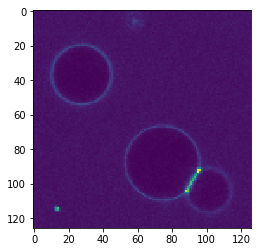

averagePixelIntensity ch1_frame  273.57
averageBackground ch1_frame  187.00039682539682
averagePixelIntensity ch2_frame  167.77
averageBackground ch2_frame  154.01534391534395
---
IMAGE ID:  18
+++++++++++++++++++++++++++++++++++++++++++++
[[73 87 20]]
INDEX:  0


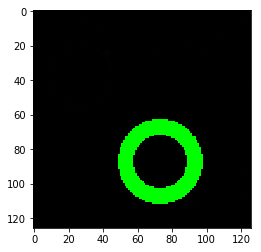

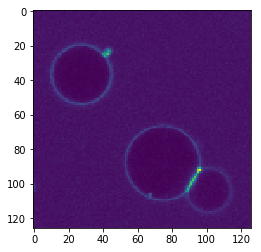

averagePixelIntensity ch1_frame  280.58
averageBackground ch1_frame  188.64391534391535
averagePixelIntensity ch2_frame  168.83
averageBackground ch2_frame  154.00780423280423
---
IMAGE ID:  19
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


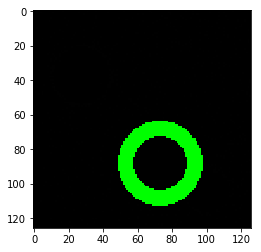

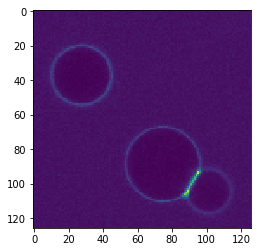

averagePixelIntensity ch1_frame  293.2
averageBackground ch1_frame  186.98373015873014
averagePixelIntensity ch2_frame  178.08
averageBackground ch2_frame  153.2383597883598
---
IMAGE ID:  20
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


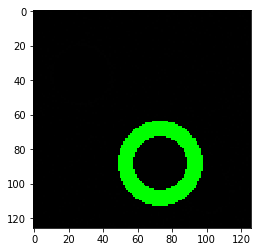

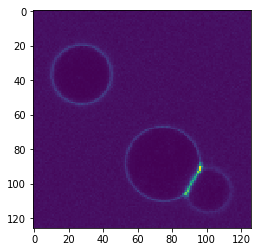

averagePixelIntensity ch1_frame  318.51
averageBackground ch1_frame  190.0876984126984
averagePixelIntensity ch2_frame  185.46
averageBackground ch2_frame  154.97619047619048
---
IMAGE ID:  21
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


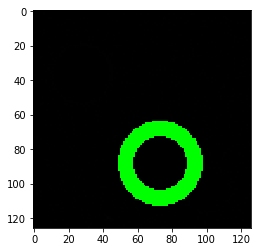

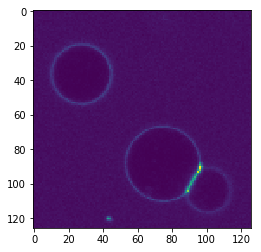

averagePixelIntensity ch1_frame  321.63
averageBackground ch1_frame  191.98174603174607
averagePixelIntensity ch2_frame  183.11
averageBackground ch2_frame  157.94933862433862
---
IMAGE ID:  22
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


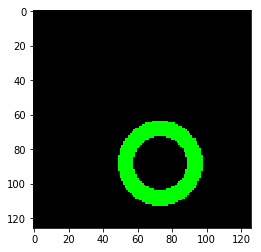

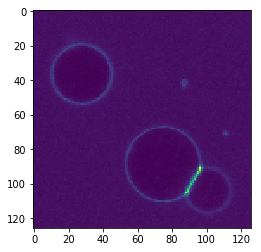

averagePixelIntensity ch1_frame  332.11
averageBackground ch1_frame  194.64431216931217
averagePixelIntensity ch2_frame  191.25
averageBackground ch2_frame  158.1382275132275
---
IMAGE ID:  23
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


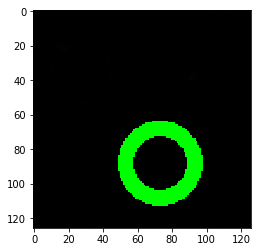

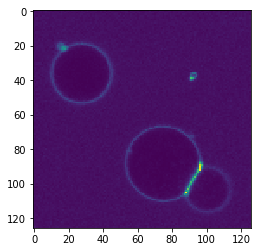

averagePixelIntensity ch1_frame  350.11
averageBackground ch1_frame  201.6424603174603
averagePixelIntensity ch2_frame  196.41
averageBackground ch2_frame  159.44298941798945
---
IMAGE ID:  24
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


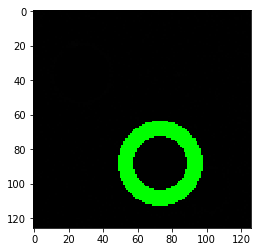

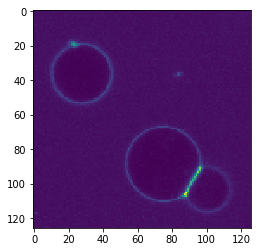

averagePixelIntensity ch1_frame  348.53
averageBackground ch1_frame  202.86150793650793
averagePixelIntensity ch2_frame  193.22
averageBackground ch2_frame  160.94880952380953
---
IMAGE ID:  25
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


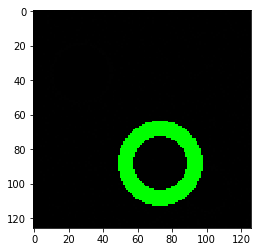

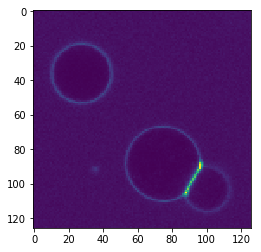

averagePixelIntensity ch1_frame  365.64
averageBackground ch1_frame  201.40383597883599
averagePixelIntensity ch2_frame  201.75
averageBackground ch2_frame  159.25
---
IMAGE ID:  26
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


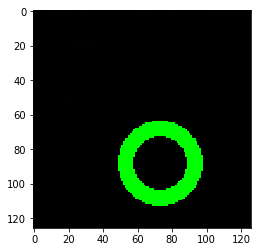

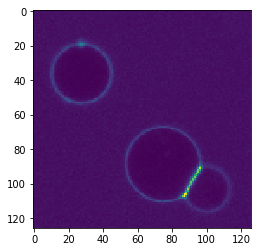

averagePixelIntensity ch1_frame  369.01
averageBackground ch1_frame  207.34523809523807
averagePixelIntensity ch2_frame  199.68
averageBackground ch2_frame  162.71547619047624
---
IMAGE ID:  27
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


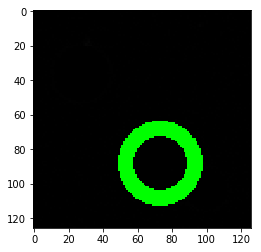

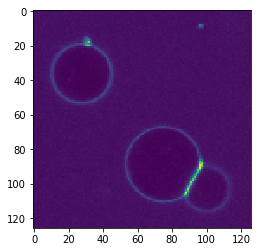

averagePixelIntensity ch1_frame  387.29
averageBackground ch1_frame  213.94391534391534
averagePixelIntensity ch2_frame  209.31
averageBackground ch2_frame  165.0345238095238
---
IMAGE ID:  28
+++++++++++++++++++++++++++++++++++++++++++++
[[73 88 20]]
INDEX:  0


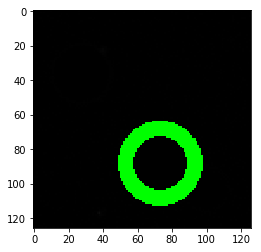

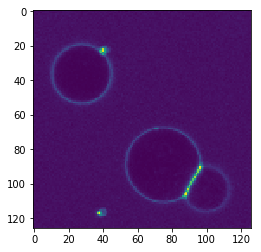

averagePixelIntensity ch1_frame  389.79
averageBackground ch1_frame  215.25661375661377
averagePixelIntensity ch2_frame  210.06
averageBackground ch2_frame  165.67023809523806
---
IMAGE ID:  29
+++++++++++++++++++++++++++++++++++++++++++++
[[73 89 20]]
INDEX:  0


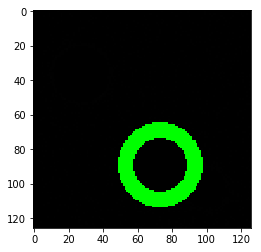

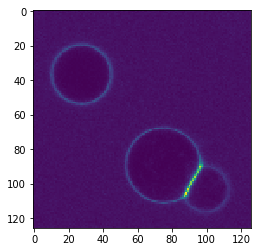

averagePixelIntensity ch1_frame  402.62
averageBackground ch1_frame  213.71402116402118
averagePixelIntensity ch2_frame  209.89
averageBackground ch2_frame  165.54047619047617
---
IMAGE ID:  30
+++++++++++++++++++++++++++++++++++++++++++++
[[73 89 20]]
INDEX:  0


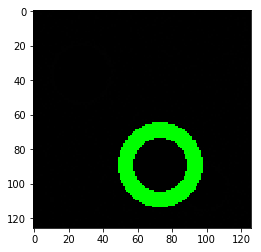

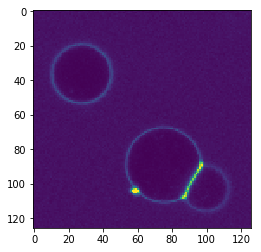

averagePixelIntensity ch1_frame  477.59
averageBackground ch1_frame  218.93902116402117
averagePixelIntensity ch2_frame  241.0
averageBackground ch2_frame  166.67380952380952
---


In [15]:


results = []
resultspd = []
for imageId in range(0,len(ch0)):
    print("IMAGE ID: ",imageId)
    indexToCheck = imageId
    resultsForThisImage = []
    #frames = allImages[indexToCheck]
    ch1_frame = ch0[imageId] 
    ch2_frame = ch1[imageId] 
    circles = circlesPerFrame[imageId]
#    cicleImage = cicleImages[imageId]
    #goodCirclesList = goodCircles[indexToCheck]
    #print("goodCirclesList",goodCirclesList)
    #plot3ChannelImage(frames,"test")
    #plt.show()
    #plt.imshow(cicleImage)
    #plt.show()
    print("+++++++++++++++++++++++++++++++++++++++++++++")
    

    index = 0
    if(len(circles) != 0 and circles!=[[]]) :
        print(circles)
        for i in circles:


            print('INDEX: ',index)
            # draw the outer circle
            img2 = ch2_frame
            img8 = (img2/256).astype('uint8')
            tmp_img = cv2.cvtColor(img8,cv2.COLOR_GRAY2BGR)
            cv2.circle(tmp_img,(i[0],i[1]),i[2],(0,255,0),8)# the last parameter is the thickness
            plt.imshow(tmp_img)
            plt.show()
            circlePixelIndexes = np.where(tmp_img==255)
            plt.imshow(ch1_frame)
            plt.show()
            realPixelIntensities_ch1_frame = ch1_frame[circlePixelIndexes[0:2]]
#            plt.plot(realPixelIntensities_ch1_frame)
#            plt.show()
            averagePixelIntensity_ch1_frame = np.round(np.mean(realPixelIntensities_ch1_frame),2)
            print("averagePixelIntensity ch1_frame ",averagePixelIntensity_ch1_frame)
            xArray = np.average(ch1_frame[:,0:30],axis=1)# get the first n lines of the img in x
            yArray = np.average(ch1_frame[0:30,:],axis=0)# get the first n lines of the img in y
            ch1_background=(np.average(xArray)+np.average(yArray))/2
            print("averageBackground ch1_frame ",ch1_background)
            #
            realPixelIntensities_ch2_frame = ch2_frame[circlePixelIndexes[0:2]]
            averagePixelIntensity_ch2_frame = np.round(np.mean(realPixelIntensities_ch2_frame),2)
            print("averagePixelIntensity ch2_frame ",averagePixelIntensity_ch2_frame)
            xArray = np.average(ch2_frame[:,0:30],axis=1)# get the first n lines of the img in x
            yArray = np.average(ch2_frame[0:30,:],axis=0)# get the first n lines of the img in y
            ch2_background=(np.average(xArray)+np.average(yArray))/2
            print("averageBackground ch2_frame ",ch2_background)
            
            
            resultsForThisImage.append([index,averagePixelIntensity_ch1_frame,averagePixelIntensity_ch2_frame,0])
            resultspd.append([imageId,index,averagePixelIntensity_ch1_frame,averagePixelIntensity_ch2_frame,0,i[0],i[1],i[2],ch1_background,ch2_background])
            
            plt.show()
            
            
            #plt.imshow(ch1_frame[:,0:30])
            #plt.plot(np.average(ch1_frame[:,0:30],axis=1))
            #print("average xarray ch1 {}".format(np.average(np.average(ch1_frame[:,0:30],axis=1))))
            #plt.show()
            #plt.imshow(ch2_frame[:,0:30])
            #plt.plot(np.average(ch2_frame[:,0:30],axis=1))
            #print("average xarray ch2 {}".format(np.average(np.average(ch2_frame[:,0:30],axis=1))))
            #plt.show()
            print("---")
            index = index +1
    else:
        print("SOMETHING")
        resultspd.append([imageId,index,None,None,None,None,None,None,None,None])
                         
    results.append(resultsForThisImage)






In [16]:
df = pd.DataFrame(resultspd)
df.columns = ['FrameId', 'VesicleId','IntCh1','IntCh2','IntCh3','xCoord','yCoord','radius','ch1_bg','ch2_bg']
df.to_csv(movie_filename+"_vesicleID_"+str(vesicleID)+".csv")
df[0:5]

,FrameId,VesicleId,IntCh1,IntCh2,IntCh3,xCoord,yCoord,radius,ch1_bg,ch2_bg
0,0,0,140.59,120.96,0,73,86,21,155.142857,132.756614
1,1,0,147.59,123.71,0,73,87,21,165.645238,136.745106
2,2,0,160.84,130.24,0,73,87,21,163.575661,138.532143
3,3,0,172.49,132.04,0,73,87,21,166.760714,140.896032
4,4,0,179.93,137.69,0,73,87,21,169.729101,141.128042


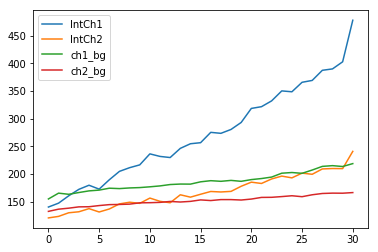

In [17]:
df[['IntCh1','IntCh2','ch1_bg','ch2_bg']].plot()

[1.         1.0676949  1.05435509 1.0748849  1.09401814 1.10305914
 1.12521912 1.12058182 1.12824074 1.13238865 1.14132222 1.15191835
 1.16783985 1.17344571 1.17266302 1.19945007 1.21264835 1.20534326
 1.21593684 1.20523583 1.22524299 1.2374514  1.25461343 1.2997212
 1.30757878 1.2981831  1.33647944 1.37901235 1.38747357 1.37753052
 1.41120916]


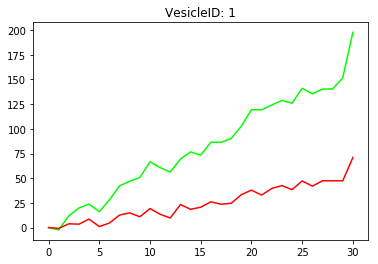

In [18]:
firstFramesOffset_ch1 = np.average(df['IntCh1'].values[0:1]) 
correctedIntensityCh1 = df['IntCh1'].values * 1/(df['ch1_bg'].values/df['ch1_bg'].values[0]) - firstFramesOffset_ch1
plt.plot(correctedIntensityCh1,c='lime')
print(df['ch1_bg'].values/df['ch1_bg'].values[0])

firstFramesOffset_ch2 = np.average(df['IntCh2'].values[0:1]) 
correctedIntensityCh2 = df['IntCh2'].values * 1/(df['ch2_bg'].values/df['ch2_bg'].values[0]) - firstFramesOffset_ch2
plt.plot(correctedIntensityCh2,c='red')
plt.title("VesicleID: {}".format(vesicleID))
plt.savefig(movie_filename+"_vesicleID_"+str(vesicleID)+".png")

output = pd.DataFrame()
output['FrameId']=df.reset_index()['FrameId']
output['avg_circle_int_Ch1']=correctedIntensityCh1
output['avg_circle_int_Ch2']=correctedIntensityCh2
output.to_csv(movie_filename+"_vesicleID_"+str(vesicleID)+"_corrected.csv")